In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import re
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc,recall_score,precision_score,accuracy_score

def parse_func_module(df) :
    module_dict = dict()
    for go in df.index :
        edges = np.array(df.loc[go,'Edges'].split(' '))
        nodes = df.loc[go,'Nodes'].split('_')
        edge_idx = [bool(re.search('_',x)) for x in edges]
        edge_list = list(edges[edge_idx])
        exclude_node = set(edges) - set(edge_list)
        for i in range(len(edge_list)) :
            edge_list[i] = tuple(edge_list[i].split('_'))
        tmp_dict = {'Nodes' : list(set(nodes) - exclude_node),'Edges' : edge_list}
        module_dict[go] = tmp_dict
    return module_dict

def module_prediction(exp_m,y,candidate_genes,n_iter=100) :

    scaler = StandardScaler()
    stand_m = scaler.fit_transform(exp_m.T.to_numpy())
    stand_df = pd.DataFrame(stand_m.T,index=exp_m.index,columns=exp_m.columns)
    acc_array = np.zeros(n_iter)
    #aucpr_array = np.zeros(n_iter)
    recall_array = np.zeros(n_iter)
    precision_array = np.zeros(n_iter)
    for i in range(n_iter) :
        x = stand_df.loc[candidate_genes,:].T.to_numpy()
        x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,stratify=y)
        lr = LogisticRegression(solver='saga',max_iter=10000).fit(x_train,y_train)
        y_predict = lr.predict(x_test)
        #precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
        acc_array[i] = accuracy_score(y_test,y_predict)
        #aucpr_array[i] = auc(recall, precision)
        recall_array[i] = recall_score(y_test,y_predict,average='macro')
        precision_array[i] = precision_score(y_test,y_predict,average='macro')
    
    return acc_array,recall_array,precision_array

def get_hub_gene_from_module(module):
    '''
    module : dict, output of parse_func_module
    '''
    g = nx.Graph()
    g.add_edges_from(module['Edges'])
    degree_list = sorted(g.degree, key=lambda x: x[1], reverse=True)
    hub_gene = degree_list[0]
    return hub_gene

def functional_module_processing(df,exp_profile,y) :
    '''
    colname of output = ["description","auc","aucpr",'hub_gene',"hub_gene_degree"]

    '''
    modules = parse_func_module(df)
    output = np.empty([df.shape[0],6],dtype=object)
    for go_idx,go in enumerate(df.index) :
        #description
        output[go_idx,0] = df.loc[go,'Description']
        gene_list = list(set(modules[go]['Nodes']).intersection(exp_profile.index))
        #prediction performance
        acc,recall,precision = module_prediction(exp_profile,y,gene_list)
        output[go_idx,1] = acc ; 
        output[go_idx,2] = recall ; output[go_idx,3] = precision 
        hub_gene = get_hub_gene_from_module(modules[go])
        output[go_idx,4] = hub_gene[0] ; output[go_idx,5] = hub_gene[1]
    
    function_module_performance = pd.DataFrame(output,index=df.index,columns=["description","acc","recall","precision",'hub_gene',"hub_gene_degree"])
    return function_module_performance

In [11]:
def processing_module_output(object) :
    value_list = []
    for x in object.split(' '):
        if x == '' :
            continue
        if x == ']' :
            continue
        elif '[' in x :
            value = x[1:]
        elif ']' in x :
            value = x[:-2]
        elif '\n' in x :
            value = x[:-3]
        else :
            value = x
        try :
            value_list.append(float(value))
        except :
            print(x)
    return value_list

def funModu_boxplot(module_df,title,fig_output) :

    plot_df = pd.DataFrame()
    for go in module_df.index :
        '''
        auc = processing_module_output(module_df.loc[go,'auc'])
        aucpr = processing_module_output(module_df.loc[go,'aucpr'])
        recall = processing_module_output(module_df.loc[go,'recall'])
        precision = processing_module_output(module_df.loc[go,'precision'])
        '''
        acc = module_df.loc[go,'acc']
        #aucpr = module_df.loc[go,'aucpr']
        recall = module_df.loc[go,'recall']
        precision = module_df.loc[go,'precision']
        description = [module_df.loc[go,'description']] * len(acc)
        tmp = pd.DataFrame({'Description' : description,'Accuracy' : acc,'Recall' : recall,'Precision' : precision})
        plot_df = pd.concat([plot_df,tmp])
    ###plot
    plt.figure(figsize=(12,7))
    df = plot_df.melt(id_vars='Description')
    sns.boxplot(data=df,x='Description',y = 'value',hue='variable',palette='Set2')
    plt.ylim([0,1.1])
    plt.xticks(rotation=90)
    plt.title(title)
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn

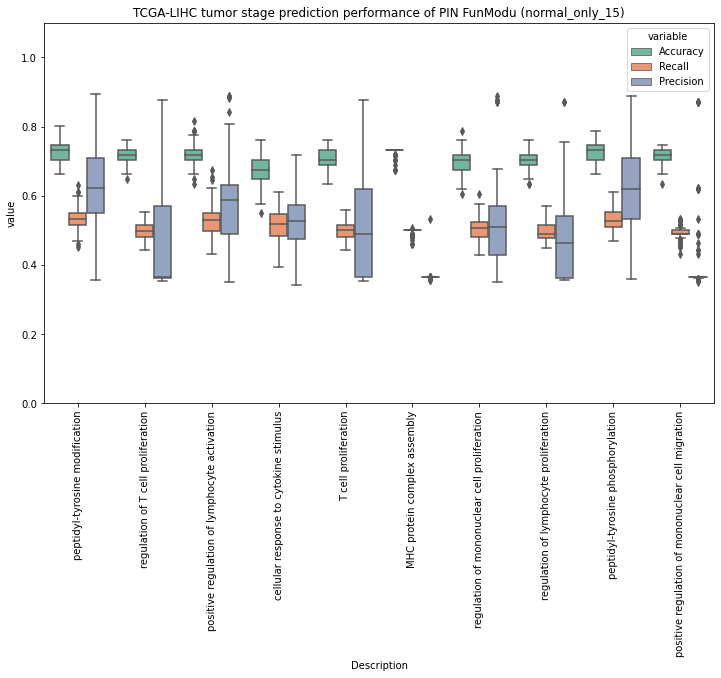

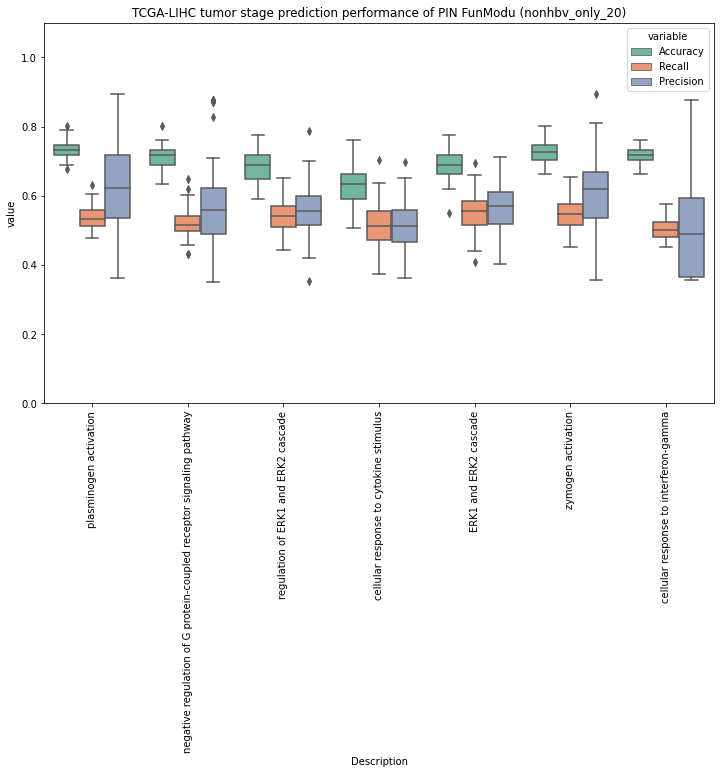

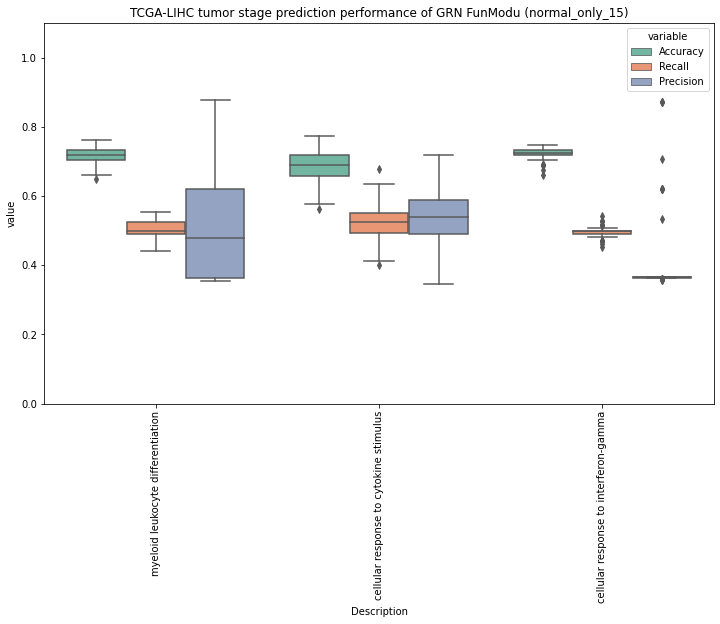

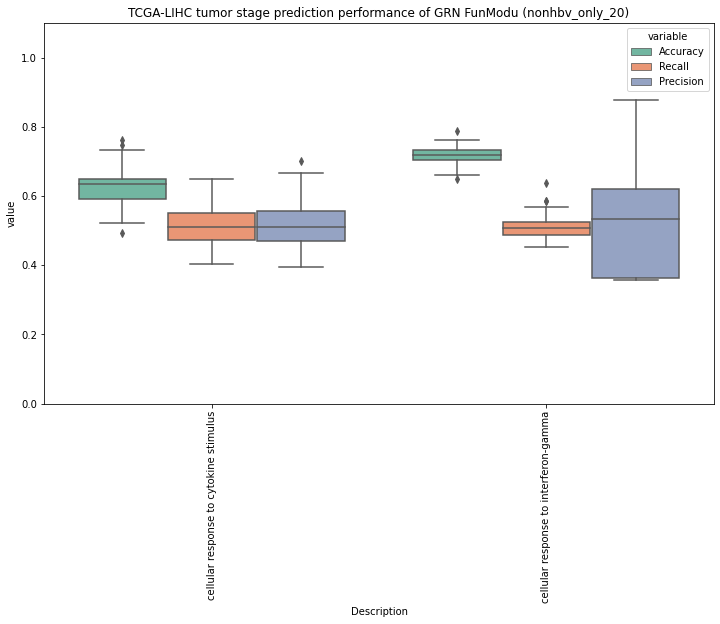

In [14]:
sheet_list = ['normal_only_15','nonhbv_only_20']
remove_sample = ['A75H','A5N0']
project= 'LIHC'
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/data/exp_profile/lihc_protein_coding_gene_std_exp_profile_tumor_only.txt",sep='\t',index_col=0)
exp_m = exp_m.drop(remove_sample,axis=1)
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/data/sample_info/sample_stage.txt',sep='\t',index_col=0)
metadata.drop(remove_sample)
stage_d = {'T1' : 'Early stage','T2' : 'Early stage','T3' : 'Late stage','T4' : 'Late stage'}
y = metadata.loc[exp_m.columns,'ajcc_tumor_pathologic_pt'].map(stage_d).values
for ppi_network in ['PIN','GRN'] :
    for sheet in sheet_list :
        df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi_network, sheet_name=sheet,index_col=1)
        module_df = functional_module_processing(df,exp_m,y)
        fig_title = "TCGA-LIHC tumor stage prediction performance of %s FunModu (%s)" % (ppi_network,sheet)
        fig_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/tumor_stage_prediction/%s_%s_funModu_%s.png" % (sheet,ppi_network,project)
        funModu_boxplot(module_df,fig_title,fig_path)


### validation dataset hbv-prediction performance

In [3]:
import os

def transform_funModu(module_df) :
    plot_df = pd.DataFrame()
    for go in module_df.index :
        des = module_df.loc[go,'description']
        auc = module_df.loc[go,'auc']
        aucpr = module_df.loc[go,'aucpr']
        tmp = pd.DataFrame({'Description' : [des] * len(auc),'AUC' : auc,'AUCPR' : aucpr})
        plot_df = pd.concat([plot_df,tmp])
    plot_df = plot_df.melt(id_vars='Description')
    plot_df.columns = ['Description','Metric','Value']
    return plot_df

def funModu_boxplot(plot_df,title,fig_output) :

    plt.figure(figsize=(12,7))
    sns.boxplot(data=plot_df,x = 'Description',y = 'Value',hue = 'Metric',palette='Set2')
    plt.xticks(rotation=90)
    plt.legend(loc='upper left')
    plt.title(title)
    plt.savefig(fig_output,dpi=300,bbox_inches='tight')

In [16]:
exp_m = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/LIRI_JP/liri_jp_coding_gene_ensid_fpkm_matrix.txt",sep='\t',index_col=0)
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/LIRI_JP/sample_metadata.txt',sep='\t',index_col=0)
patients = list(set(metadata.index).intersection(exp_m.columns))
exp_m = exp_m.loc[:,patients]
metadata = metadata.loc[patients,:]

In [19]:
tumor_idx = metadata.index[np.where(metadata['Sample_type'] == 'Cancer')]
donor_dict = dict(zip(tumor_idx,metadata.loc[tumor_idx,'icgc_donor_id']))
tumor_exp_m = exp_m.loc[:,tumor_idx]
tumor_exp_m = tumor_exp_m.rename(columns=donor_dict)
donor_metadata = pd.read_csv("/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/LIRI_JP/donor.LIRI-JP.tsv",sep='\t',index_col=0)
#y = donor_metadata.loc[tumor_exp_m.columns,"donor_tumour_stage_at_diagnosis"].values

stage_d = {1 : 'Early stage',2 : 'Early stage',3 : 'Late stage',4 : 'Late stage'}
y = donor_metadata.loc[tumor_exp_m.columns,"donor_tumour_stage_at_diagnosis"].map(stage_d).values

/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bruce1996/anaconda3/lib/python3.9/site-packages/sklearn

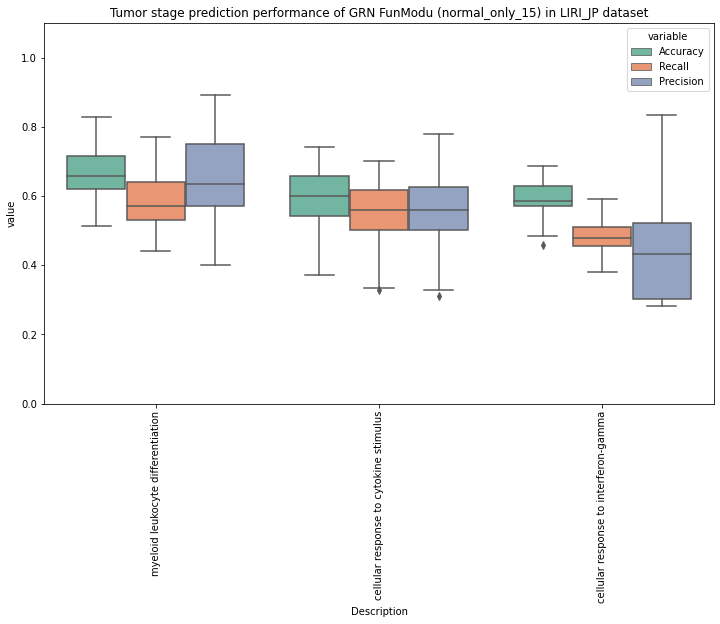

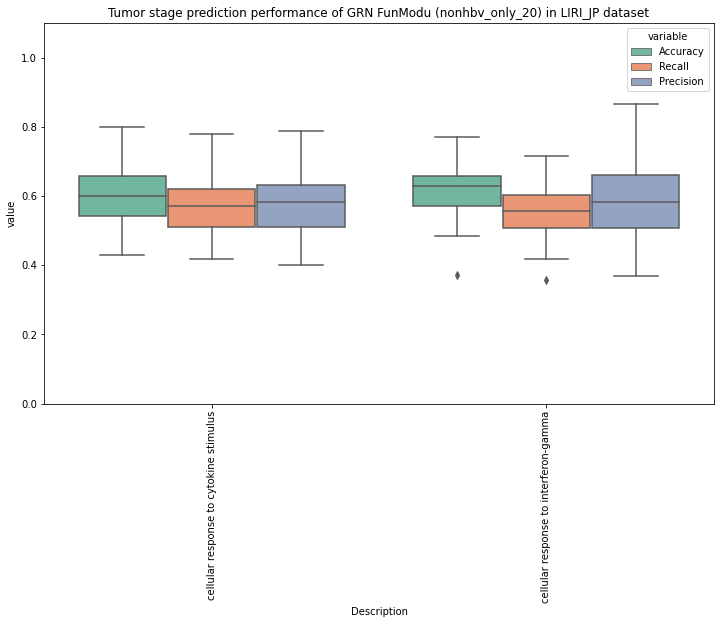

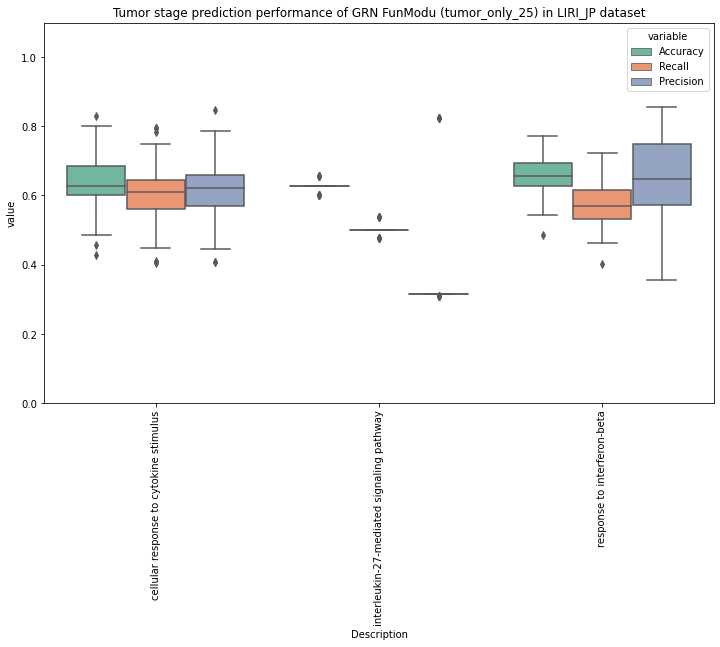

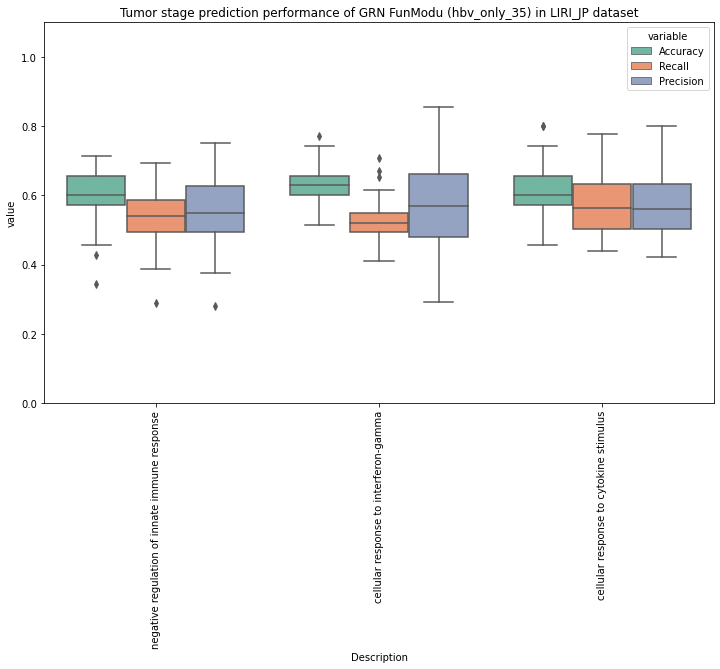

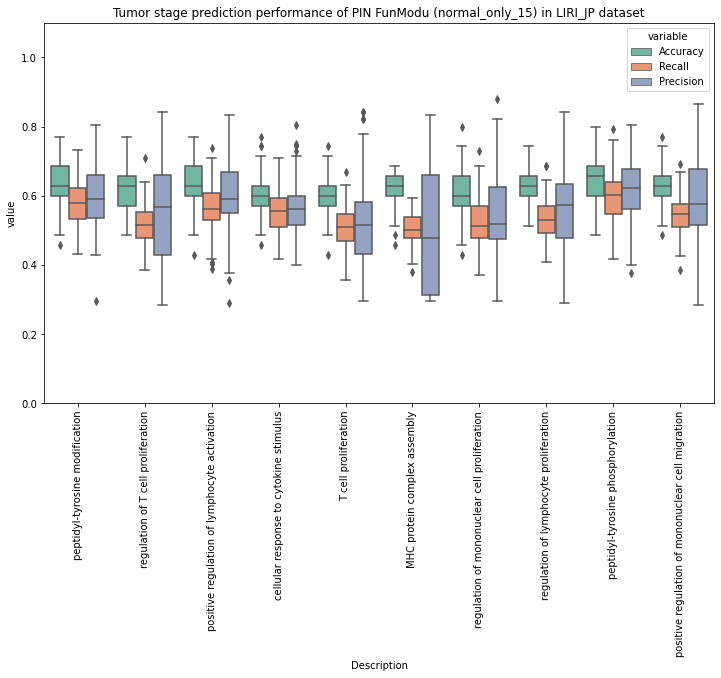

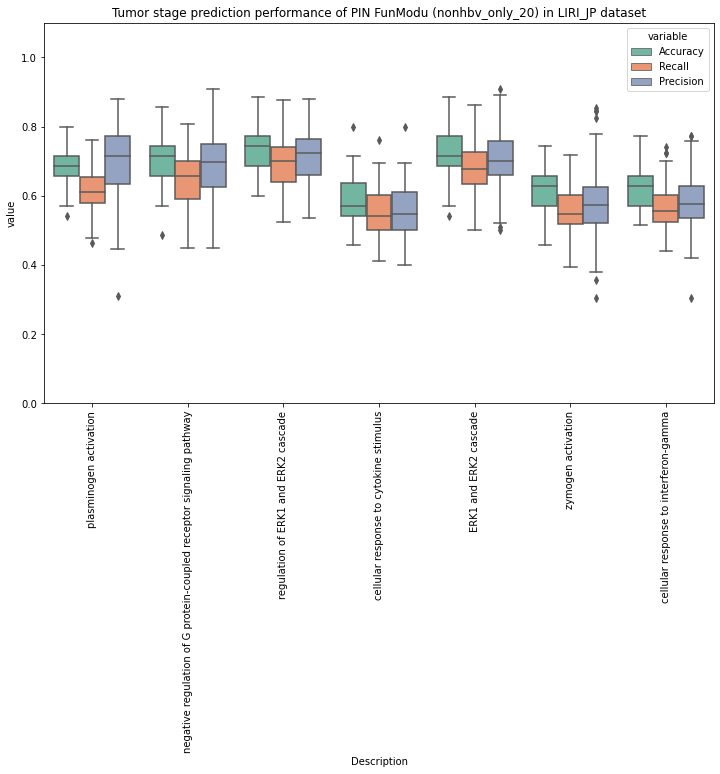

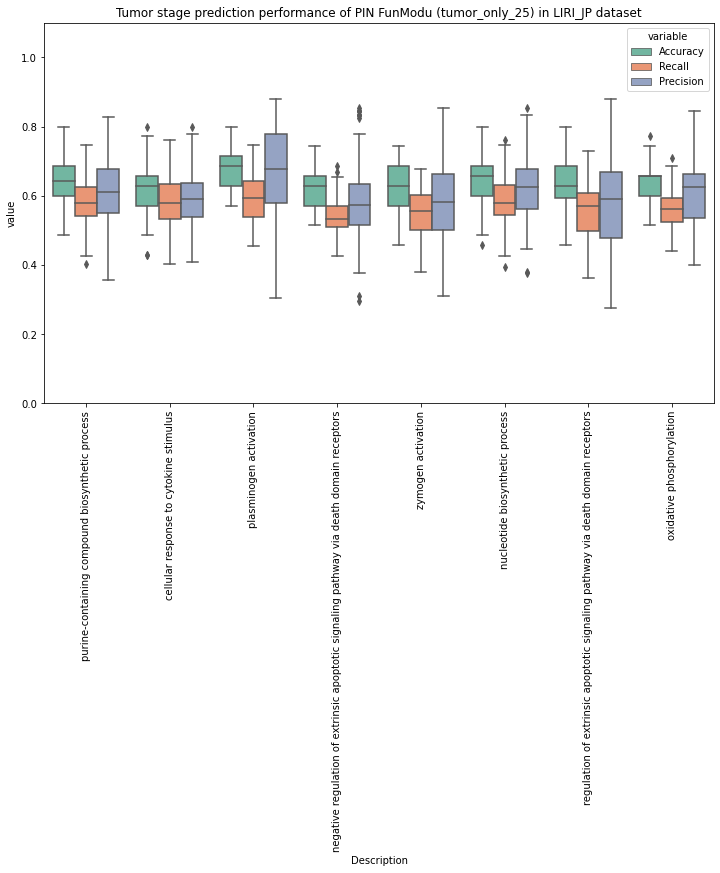

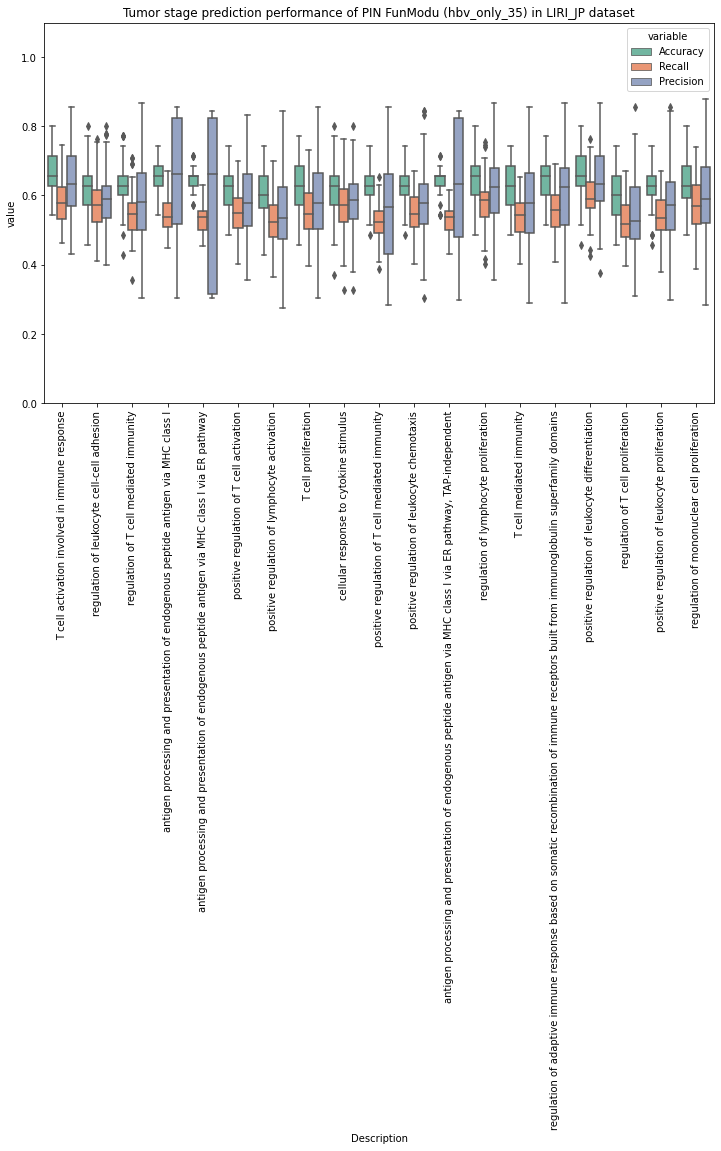

In [21]:
sheet_list = ['normal_only_15','nonhbv_only_20','tumor_only_25','hbv_only_35']
project = 'LIRI_JP'
for ppi_network in ['GRN','PIN'] :
    for sheet in sheet_list :
        df = pd.read_excel("/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/Summary_table_of_%s_FunModu.xlsx" % ppi_network, sheet_name=sheet,index_col=1)
        module_df = functional_module_processing(df,tumor_exp_m,y)
        fig_title = "Tumor stage prediction performance of %s FunModu (%s) in %s dataset" % (ppi_network,sheet,project)
        fig_path = "/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/tumor_stage_prediction/"
        if os.path.exists(fig_path) == False :
            os.mkdir(fig_path)
        fig_name = "%s_%s_funModu_%s.png" % (sheet,ppi_network,project)
        #plot_df = transform_funModu(module_df)
        funModu_boxplot(module_df,fig_title,fig_path + fig_name)